In [1]:
import numpy as np
import itertools

from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve, _SigmoidCalibration
from sklearn.metrics import brier_score_loss, log_loss
from scipy.special import expit

from ampligraph.datasets import load_wn11
from ampligraph.latent_features.models import TransE, ComplEx

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
X = load_wn11()

In [4]:
X_valid_pos = X['valid'][X['valid_labels']]
X_valid_neg = X['valid'][~X['valid_labels']]

X_test_pos = X['test'][X['test_labels']]
X_test_neg = X['test'][~X['test_labels']]

In [5]:
model = TransE(batches_count=64, seed=0, epochs=1000, k=100, eta=20,
               optimizer='adam', optimizer_params={'lr':0.0001},
               loss='pairwise', verbose=False)

model.fit(X['train'])

In [6]:
scores1 = model.predict(X['test'])

In [7]:
model = TransE(batches_count=64, seed=0, epochs=1000, k=100, eta=20,
               optimizer='adam', optimizer_params={'lr':0.0001},
               loss='self_adversarial', verbose=False)

model.fit(X['train'])

In [8]:
scores2 = model.predict(X['test'])

In [9]:
model = TransE(batches_count=64, seed=0, epochs=1000, k=100, eta=20,
               optimizer='adam', optimizer_params={'lr':0.0001},
               loss='multiclass_nll', verbose=False)

model.fit(X['train'])

In [10]:
scores3 = model.predict(X['test'])

In [11]:
model = TransE(batches_count=64, seed=0, epochs=1000, k=100, eta=20,
               optimizer='adam', optimizer_params={'lr':0.0001},
               loss='nll', verbose=False)

model.fit(X['train'])

In [12]:
scores4 = model.predict(X['test'])

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

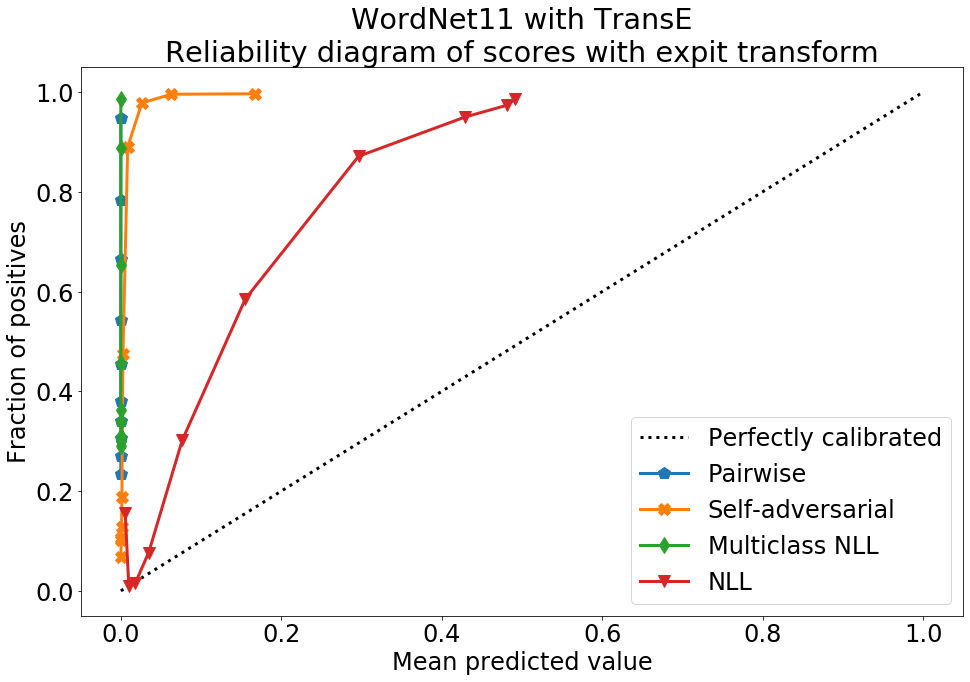

In [18]:
plt.rcParams.update({'font.size': 24})

fig = plt.figure(figsize=(14, 10))

ax1 = plt.gca()
#ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
#ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", lw=3, label="Perfectly calibrated")
#ax1.grid()

fraction_of_positives, mean_predicted_value = calibration_curve(X['test_labels'], 
                                                                expit(scores1), n_bins=10, strategy="quantile")
ax1.plot(mean_predicted_value, fraction_of_positives, "p-", markersize=12, lw=3, label="Pairwise")

fraction_of_positives, mean_predicted_value = calibration_curve(X['test_labels'], 
                                                                expit(scores2), n_bins=10, strategy="quantile")
ax1.plot(mean_predicted_value, fraction_of_positives, "X-", markersize=12, lw=3, label="Self-adversarial")

fraction_of_positives, mean_predicted_value = calibration_curve(X['test_labels'], 
                                                                expit(scores3), n_bins=10, strategy="quantile")
ax1.plot(mean_predicted_value, fraction_of_positives, "d-", markersize=12, lw=3, label="Multiclass NLL")

fraction_of_positives, mean_predicted_value = calibration_curve(X['test_labels'], 
                                                                expit(scores4), n_bins=10, strategy="quantile")
ax1.plot(mean_predicted_value, fraction_of_positives, "v-", markersize=12, lw=3, label="NLL")


# ax2.hist(expit(scores1), range=(0, 1), bins=10,
#          histtype="step", lw=2, label="Pairwise")

# ax2.hist(expit(scores2), range=(0, 1), bins=10,
#          histtype="step", lw=2, label="Self-adversarial")

# ax2.hist(expit(scores3), range=(0, 1), bins=10,
#          histtype="step", lw=2, label="Multiclass NLL")

# ax2.hist(expit(scores4), range=(0, 1), bins=10,
#          histtype="step", lw=2, label="NLL")


ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('WordNet11 with TransE\nReliability diagram of scores with expit transform')

ax1.set_xlabel("Mean predicted value")
# ax2.set_ylabel("Count")
# ax2.legend(loc="upper center", ncol=2)


plt.tight_layout()